# 645 Mini project - SeeDB: efficient data-driven visualization recommendations to support visual analytics

#### Team members:<br>
Shreya - shreyashivva@umass.edu<br>
Nihar - nchinta@umass.edu<br>
Snigdha - slnu@umass.edu<br>
Pranav - prajain@umass.edu<br>

In [505]:
#Installing dataset and importing libraries
!pip install ucimlrepo
!pip install pandasql
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
from sklearn.model_selection import KFold
import copy
from itertools import product
import scipy

In [506]:
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
X = census_income.data.features 
y = census_income.data.targets 

In [507]:
# variable information 
print(census_income.variables)

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [508]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [509]:
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [510]:
# Concatenate X and y along columns (axis=1) to form the dataset
census_income_dataset = pd.concat([X, y], axis=1)

# Replacing '-' in column names with '_'
census_income_dataset.columns = census_income_dataset.columns.str.replace('-', '_')

census_income_dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [511]:
# Drop the 'fnlwgt' and 'education_num' column from the census dataset 
census_income_dataset.drop('fnlwgt', axis=1, inplace=True)
census_income_dataset.drop('education_num', axis=1, inplace=True)

In [512]:
# Reducing categories and handling Nan and ? values

census_income_dataset['education'] = census_income_dataset['education'].replace(['1st-4th','5th-6th'],'primary')
census_income_dataset['education'] = census_income_dataset['education'].replace(['9th','7th-8th','10th'],'secondary')
census_income_dataset['education'] = census_income_dataset['education'].replace(['11th','12th','HS-grad'],'junior_college')

census_income_dataset.loc[census_income_dataset['native_country'] != 'United-States', 'native_country'] = 'Non-US'

census_income_dataset['occupation'] = census_income_dataset['occupation'].replace(['Craft-repair','Handlers-cleaners','Machine-op-inspct'],'skilled_workers')
census_income_dataset['occupation'] = census_income_dataset['occupation'].replace(['Other-service','Sales','Priv-house-serv'],'sales_and_service')
census_income_dataset['occupation'] = census_income_dataset['occupation'].replace(['?'],'Unknown_occupation')
census_income_dataset['occupation'].fillna('Unknown_occupation', inplace=True)

census_income_dataset['workclass'] = census_income_dataset['workclass'].replace(['?'],'Unknown_workclass')
census_income_dataset['workclass'].fillna('Unknown_workclass', inplace=True)

census_income_dataset['income'] = census_income_dataset['income'].replace(['<=50K.'],'<=50K')
census_income_dataset['income'] = census_income_dataset['income'].replace(['>50K.'],'>50K')

In [513]:
#Forming the user-specified query and reference query based on marital status 

user_query = "select * from census_income_dataset where marital_status in ('Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse','Seperated')"

reference_query = "select * from census_income_dataset where marital_status not in ('Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse','Seperated')"

married_dataset = sqldf(user_query, globals())
unmarried_dataset = sqldf(reference_query, globals())

# married_dataset.head()

In [514]:
# Plot size
plt.rcParams['figure.figsize'] = [10, 4]

# top K aggregate views, where k = 5
K = 5

In [515]:
#Function to generate visualizations for married and unmarried datasets

def generate_visualization(married_data, unmarried_data, view_definition):
    num_categories = len(married_data)

    group_by = view_definition[0]
    measure = view_definition[1]
    function = view_definition[2]

    married_values = married_data.iloc[:, 1].tolist()
    unmarried_values = unmarried_data.iloc[:, 1].tolist()

    fig, ax = plt.subplots()
    index = np.arange(num_categories)
    bar_width = 0.35

    married_plot = ax.bar(index, married_values, bar_width, color='#004c6d', label='Married')
    unmarried_plot = ax.bar(index + bar_width, unmarried_values, bar_width, color='#9dc6e0', label='Unmarried')

    ax.set_xticks(index)
    ax.set_xticklabels(married_data.iloc[:, 0].tolist(), rotation=90, fontsize=12)
    ax.set_ylabel('{}({})'.format(function, measure))
    ax.set_title('{} vs {}({})'.format(group_by, function, measure))
    ax.legend()

    fig.tight_layout()
    plt.show()
    print("\n")


In [516]:
#KL divergence method

def kl_divergence(married_data, unmarried_data):
    mlist = married_data.reshape(-1)
    ulist = unmarried_data.reshape(-1)
    
    m_sum = np.sum(mlist)
    u_sum = np.sum(ulist)

    # Check if either of the sums is zero or negative
    if m_sum <= 0 or u_sum <= 0:
        return 0.

    m_prob = mlist / m_sum
    um_prob = ulist / u_sum

    kl_div = []

    for x, y in zip(m_prob, um_prob):
        if x > 0 and y > 0:
            kl_div.append(scipy.special.kl_div([x, 1-x], [y, 1-y]))

    return np.sum(kl_div)


In [517]:
#Splitting the initial dataset into N phases used for pruning optimization

def dataset_split(married_data, unmarried_data, phases):
    married_collection = {}
    unmarried_collection = {}
    
    # Initialize KFold cross-validator
    kf = KFold(n_splits=phases)
    
    # Split married data into multiple folds
    for fold_id, (train_index, test_index) in enumerate(kf.split(married_data)):
        married_fold_data = married_data.iloc[train_index]
        married_collection[fold_id] = married_fold_data
    
    # Split unmarried data into multiple folds
    for fold_id, (train_index, test_index) in enumerate(kf.split(unmarried_data)):
        unmarried_fold_data = unmarried_data.iloc[train_index]
        unmarried_collection[fold_id] = unmarried_fold_data
    
    return married_collection, unmarried_collection

In [518]:
#Defining distribution of a,f,m

measures= ['age','fnlwgt', 'education_num','capital_gain','capital_loss','hours_per_week']
dimensions = ['workclass','education','marital_status','occupation','relationship','race','sex','native_country','income']
functions = ['sum','avg','max','min','count']

measures.remove('education_num')
measures.remove('fnlwgt')


### Sharing Based Optimisation

In [519]:
# Defining dictionary of all combinations of functions, measures and dimensions
views_superset = {k: v for k,v in enumerate(list(product(functions, measures, dimensions)))}

In [520]:
def generate_views_data(views_info, data_tables):
    aggregated_measures = []
    grouping_attributes = []
    views_data = {}
    columns_info = {}

    for view_id, view_info in views_info.items():
        func, meas, attr, *extra = view_info
        aggregated_measures.append('{}({}) as {}_{}'.format(func, meas, func, meas))
        grouping_attributes.append('{}'.format(attr))

    aggregated_measures = ', '.join(set(aggregated_measures))
    grouping_attributes = list(set(grouping_attributes))

    for table in data_tables:
        views_data[table] = defaultdict(dict)
        columns_info[table] = defaultdict(dict)
        current_view_id = 0
        for dimension in grouping_attributes:
            query = "select {}, {} from {} group by {};".format(dimension, aggregated_measures, table, dimension)
            df = sqldf(query, globals())
            views_data[table][current_view_id] = df.values.tolist()
            columns_info[table][current_view_id] = df.columns
            current_view_id += 1

    return views_data, columns_info

In [521]:
# Creating a dataframe of view scores

tables_to_process = ['married_dataset', 'unmarried_dataset']
views_data, column_names = generate_views_data(views_superset, tables_to_process)

view_scores_data = []

for view_id in range(len(dimensions)):

    married_dataframe = pd.DataFrame(views_data['married_dataset'][view_id], columns=column_names['married_dataset'][view_id])
    unmarried_dataframe = pd.DataFrame(views_data['unmarried_dataset'][view_id], columns=column_names['unmarried_dataset'][view_id])

    column_list = column_names['married_dataset'][view_id]
    attribute = column_list[0]

    for function_measure in column_list[1:]:
        statistics = []
        split_fm = function_measure.split("_", 1)
        statistics.append(split_fm[0])
        statistics.append(split_fm[1])
        statistics.append(attribute)

        married_data_filtered = married_dataframe.loc[married_dataframe[attribute].notnull(), [attribute, function_measure]]
        unmarried_data_filtered = unmarried_dataframe.loc[unmarried_dataframe[attribute].notnull(), [attribute, function_measure]]

        joined_data = married_data_filtered.join(unmarried_data_filtered.set_index(attribute), on=attribute, how="inner", lsuffix='_married', rsuffix='_unmarried')

        married_values = joined_data['{}_married'.format(function_measure)].values
        unmarried_values = joined_data['{}_unmarried'.format(function_measure)].values

        utility_score = kl_divergence(married_values, unmarried_values)

        statistics.append(utility_score)

        view_scores_data.append(statistics)
        

view_scores_dataframe = pd.DataFrame(view_scores_data, columns=['function', 'measure', 'attribute', 'view_score'])
view_scores_sorted = view_scores_dataframe.sort_values('view_score', ascending=False).reset_index(drop=True)
print(view_scores_sorted)

    function         measure   attribute  view_score
0        sum    capital_loss      income    1.265160
1      count    capital_loss      income    1.113352
2      count             age      income    1.113352
3      count  hours_per_week      income    1.113352
4      count    capital_gain      income    1.113352
..       ...             ...         ...         ...
175      min    capital_gain        race    0.000000
176      min    capital_loss  occupation    0.000000
177      min             age      income    0.000000
178      max             age      income    0.000000
179      min    capital_loss        race    0.000000

[180 rows x 4 columns]


In [522]:
# Function to generate top K visualizations

def generate_top_k_visualizations(sorted_view_scores, k):
    for viz_id in range(k):
        func = sorted_view_scores.iloc[viz_id]['function']
        meas = sorted_view_scores.iloc[viz_id]['measure']
        attr = sorted_view_scores.iloc[viz_id]['attribute']

        view_definition = [attr, meas, func]

        query_married = "SELECT {}, {}({}) FROM married_dataset GROUP BY {};".format(attr, func, meas, attr)
        married_df = sqldf(query_married, globals())

        query_unmarried = "SELECT {}, {}({}) FROM unmarried_dataset GROUP BY {};".format(attr, func, meas, attr)
        unmarried_df = sqldf(query_unmarried, globals())

        married_values = married_df.iloc[:, 0].tolist()
        unmarried_values = unmarried_df.iloc[:, 0].tolist()

        for value in married_values:
            if value not in unmarried_values:
                value_column = func + '(' + meas + ')'
                temp_data = {}
                temp_data[attr] = value
                temp_data[value_column] = 0
                df = pd.DataFrame(temp_data, index=[0])
                unmarried_df = pd.concat([unmarried_df, df], ignore_index=True)

        for value in unmarried_values:
            if value not in married_values:
                value_column = func + '(' + meas + ')'
                temp_data = {}
                temp_data[attr] = value
                temp_data[value_column] = 0
                df = pd.DataFrame(temp_data, index=[0])
                married_df = pd.concat([married_df, df], ignore_index=True)

        married_df = married_df.sort_values(attr, ascending=True)
        unmarried_df = unmarried_df.sort_values(attr, ascending=True)

        generate_visualization(married_df, unmarried_df, view_definition)

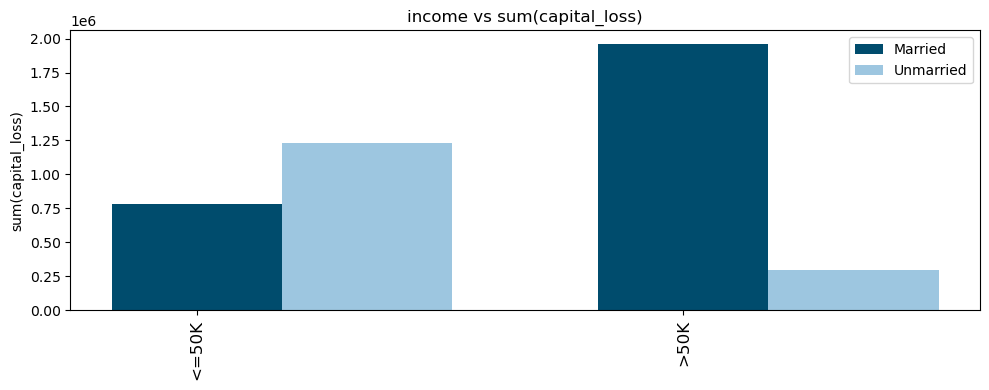

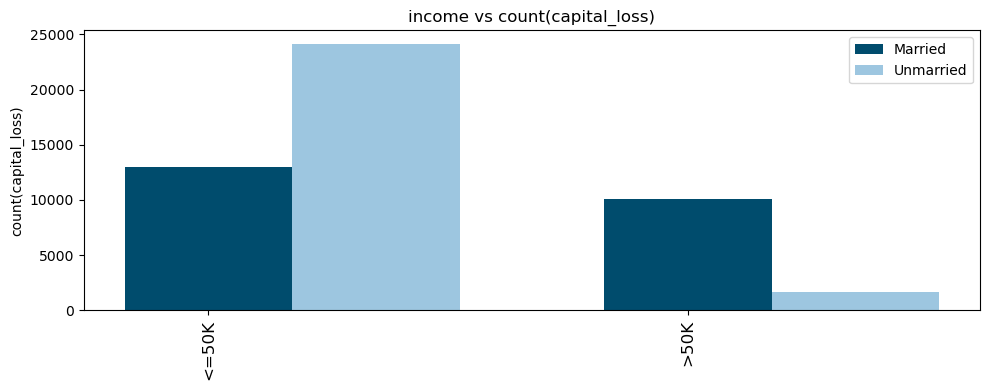

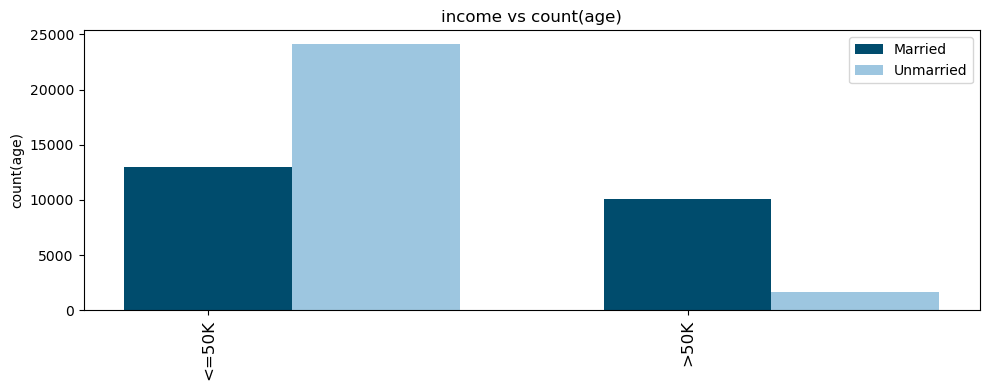

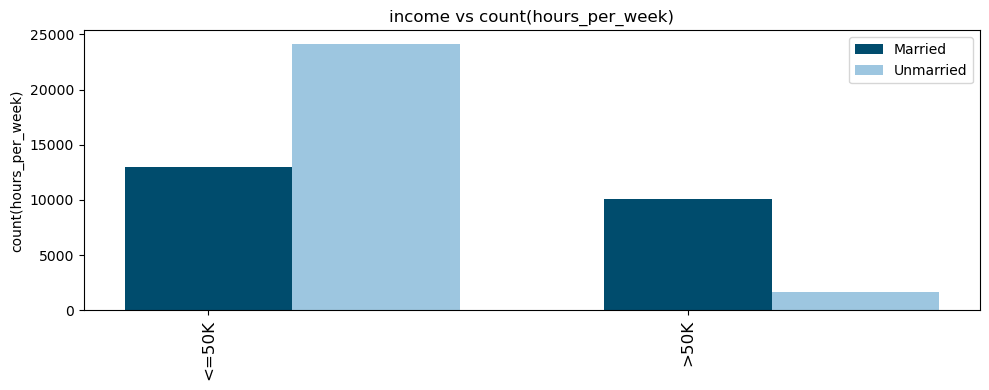

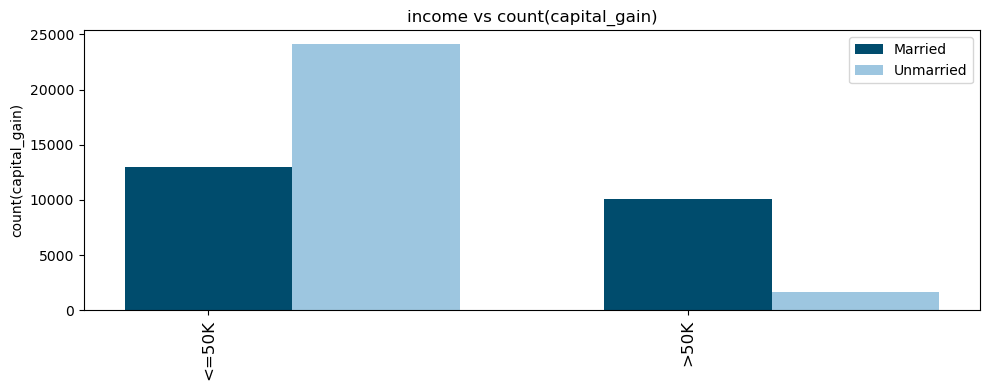

In [523]:
# Top K views after Sharing based optimisation
generate_top_k_visualizations(view_scores_sorted, K)

### Pruning Based Optimization - Confidence Interval Based Pruning

In [524]:
view_scores_data_t = []

# Creating a dictionary of all the possible views based on the combination of functions, measures and dimensions
current_views_set = {k: v for k,v in enumerate(list(product(functions, measures, dimensions)))}

# Setting the hyper-parameters for the pruning algorithm
delta = 0.09
phases = 12

# Splitting the dataset into N chunks for N-phased execution
married_df, unmarried_df = dataset_split(married_dataset,unmarried_dataset,phases)

In [525]:
# N-phased execution with pruning after every phase
for i in range(phases):

    married_partition = married_df[i]
    unmarried_partition = unmarried_df[i]
    tables = ['married_partition', 'unmarried_partition']
    data, col_names = generate_views_data(current_views_set, tables)
    
    
    set_length = len(current_views_set)

    for view_id in range(len(dimensions)):
    
        married_dataframe = pd.DataFrame(views_data['married_dataset'][view_id], columns=column_names['married_dataset'][view_id])
        unmarried_dataframe = pd.DataFrame(views_data['unmarried_dataset'][view_id], columns=column_names['unmarried_dataset'][view_id])
        
        column_list = column_names['married_dataset'][view_id]
        attribute = column_list[0]
        
        for function_measure in column_list[1:]:
            statistics = []
            split_fm = function_measure.split("_", 1)
            statistics.append(split_fm[0])
            statistics.append(split_fm[1])
            statistics.append(attribute)
        
            married_data_filtered = married_dataframe.loc[married_dataframe[attribute].notnull(), [attribute, function_measure]]
            unmarried_data_filtered = unmarried_dataframe.loc[unmarried_dataframe[attribute].notnull(), [attribute, function_measure]]
        
            joined_data = married_data_filtered.join(unmarried_data_filtered.set_index(attribute), on=attribute, how="inner", lsuffix='_married', rsuffix='_unmarried')
        
            married_values = joined_data['{}_married'.format(function_measure)].values
            unmarried_values = joined_data['{}_unmarried'.format(function_measure)].values
        
            utility_score = kl_divergence(married_values, unmarried_values)


            statistics.append(utility_score)
            statistics.append(i)
            view_scores_data_t.append(statistics)


    view_scores_t = pd.DataFrame(view_scores_data_t,columns=['function','measure','attribute','view_scores','phases'])
    view_scores_list = view_scores_t.iloc[:, 0:4].groupby(['function', 'measure','attribute'])['view_scores'].apply(list).reset_index(name='view_scores')


#Hoeffding-Serfling inequality for pruning

    if i > 0:

      m, N = i+1, phases
      eps_m = np.sqrt((1/2*m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))

      view_scores_list['Mean'] = view_scores_list['view_scores'].apply(np.mean)
      views_ranking = view_scores_list.sort_values('Mean',ascending=False)

      #Taking top K=5 view ranks  

      lower_bound = abs(views_ranking.iloc[K-1,4] - eps_m)
      viewset_size = len(views_ranking)
      drop_labels = []
      for s in range(len(views_ranking)):
        if views_ranking.iloc[s,4]  < lower_bound:
          drop_labels.append(s)

      views_ranking_updated = views_ranking.drop(drop_labels)


      temp = views_ranking_updated.iloc[:, 0:3]
      new_dict = {}

      for l in range(len(temp)):
        new_dict[l] = (temp.iloc[l,0],temp.iloc[l,1],temp.iloc[l,2])

      current_views_set = copy.deepcopy(new_dict)
      
print('Total number of pruned views in {} phases : {} \n'.format(i+1, len(views_superset)-len(current_views_set)))

Total number of pruned views in 12 phases : 165 



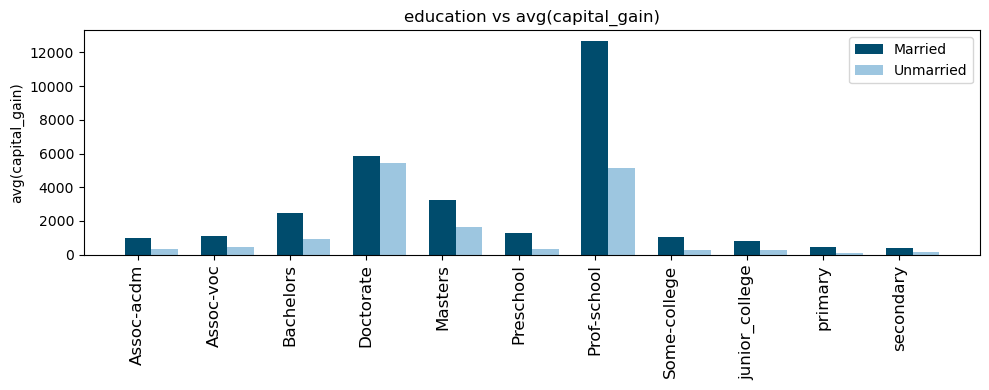

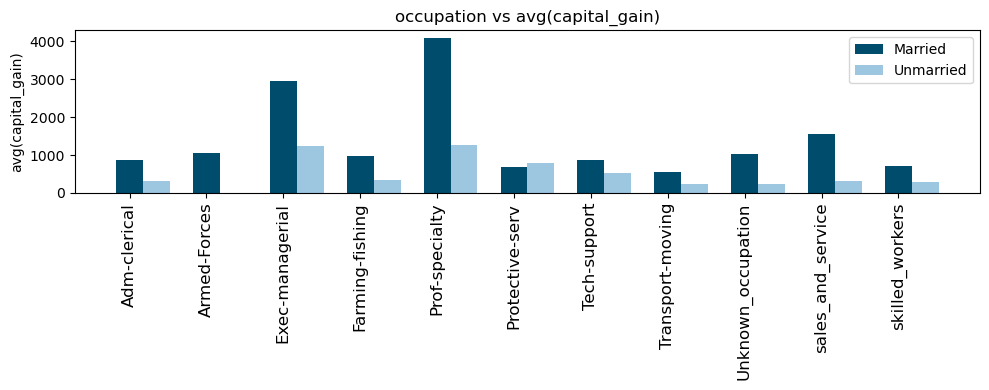

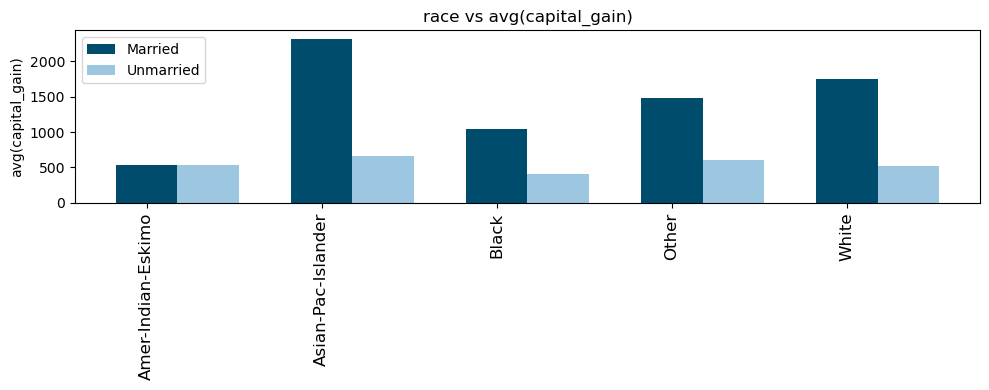

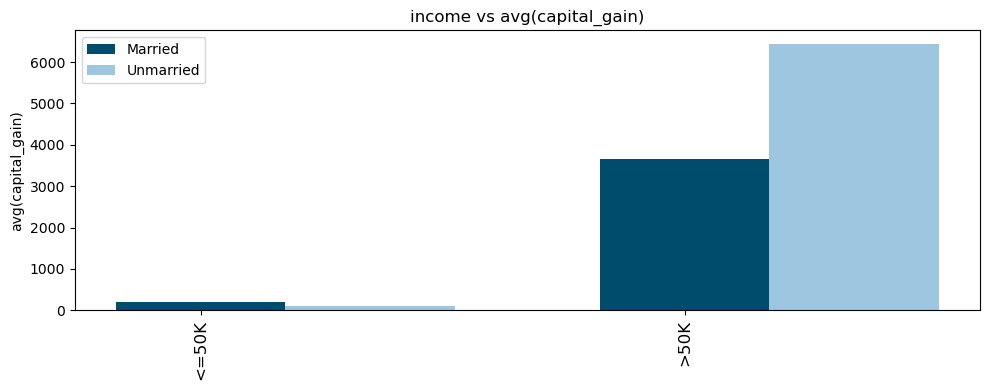

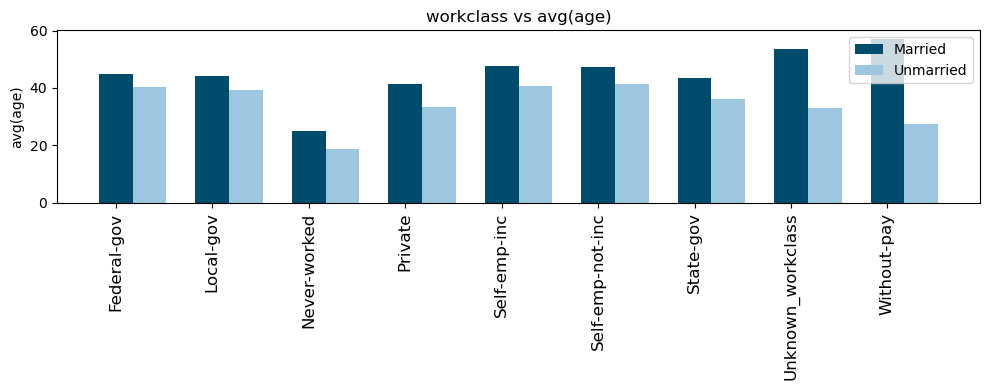

In [526]:
generate_top_k_visualizations(views_ranking_updated, K)